# Introduction

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Activation, Dense, Dropout, Flatten, Lambda, LSTM, GRU
from sklearn import metrics

# Data Importation

In [108]:
dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')

In [109]:
dfx.head()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
0,53,0.166262,0.170520,0.176371,0.197565,0.212814,0.957631,1.177679,3.207268,3.213602,...,14.700766,15.856531,15.906414,15.910547,16.079702,16.516175,16.988851,16.996101,17.019988,17.056403
1,7229,0.053270,0.133652,0.161603,0.530531,0.692537,0.730291,0.784066,1.023311,1.059203,...,10.420048,11.577627,18.070029,18.825891,19.248378,19.539560,19.723312,19.978294,20.052356,20.123709
2,7770,0.600593,1.127467,1.289813,2.598660,3.826711,4.851020,5.025722,5.262254,5.282915,...,24.635121,25.967167,26.270768,28.028523,29.584844,31.183257,31.218086,31.285777,33.160938,33.360947
3,7002,0.136037,0.655734,0.992514,1.490964,2.246825,2.855319,3.208054,3.325092,4.202108,...,13.473805,13.688518,14.028203,14.178543,14.783635,15.151632,16.003356,16.282885,17.249543,17.259610
4,7678,0.200614,0.257171,0.288137,0.314078,0.486903,0.499591,0.534961,0.623986,0.639313,...,11.298341,12.214740,13.072630,13.952573,14.013957,14.476091,14.724149,16.883795,17.052340,19.289922


In [151]:
dfy.head()
dfx_test.tail()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
28599,9456,1.501446,1.935893,2.100466,2.144410,2.259503,2.269867,2.292989,2.346420,2.724702,...,20.970412,20.984293,20.997030,21.016212,21.039446,21.044450,21.277555,21.723172,22.037007,22.061580
28600,10064,0.059309,0.116247,0.163038,0.262012,0.301379,1.813054,2.068066,2.168285,2.232430,...,21.518761,22.137357,22.504569,23.102718,23.155953,23.254136,23.302653,23.480564,23.539625,23.585673
28601,10045,0.563164,1.563625,1.677879,1.881264,2.583920,2.948714,3.112856,3.299712,6.040656,...,22.736962,22.842219,22.905865,22.971377,22.982869,23.614314,23.650248,23.807894,24.425525,25.271358
28602,9570,1.052182,1.066127,1.805688,1.824387,1.864275,2.420648,2.431845,2.757334,3.235232,...,35.510581,35.700678,37.062503,37.789828,38.569837,39.213227,41.504263,41.963118,41.983141,42.038623
28603,9836,0.004843,0.026412,0.033590,0.307083,0.311297,0.426553,0.449229,0.453311,1.199124,...,17.048710,17.993623,18.675683,18.827421,18.847187,18.923304,18.929989,19.166302,19.362858,19.370905


In [111]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

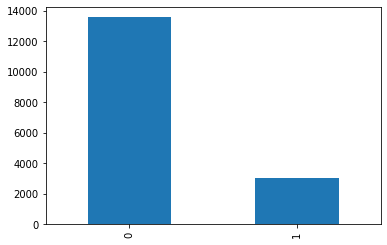

In [112]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [113]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
diff

[8046]

* **Create Xtrain ytrain:** numpy array from df, with dimensions *(sample_nb, timestep_nb, feature_nb)*

In [119]:
def getX(dfx):    
    # X: Exclude neuron_id column from array
    X = dfx.iloc[:,1:].values
    X = X[..., np.newaxis]
    return X

X = getX(dfx)

# y: Delete useless dimension 
y = dfy.values
y = np.reshape(y, (y.shape[0],))
y.shape

(16635,)

* **Balance dataset:** Under-sample class2 to have same number of samples in both classes

In [120]:
# SET SEED pour reproducibilité

# Extract class2 indices from Y
y_class1_ix = np.where(y == 1)[0]
y_class2_ix = np.where(y == 0)[0]
print(len(y_class1_ix), len(y_class2_ix))

# Under-sample class2 to get balanced classes
y_class2_ix_undersampled = np.random.choice(y_class2_ix, len(y_class1_ix))
print(y_class2_ix_undersampled)

# Concatenate the undersampled_class2_array and the class1_array
balanced_ix = np.concatenate((y_class1_ix, y_class2_ix_undersampled), axis=0)
np.random.shuffle(balanced_ix)
print(balanced_ix)

3058 13577
[10583    83  5763 ...  7789  8642  6091]
[  430  2353 15397 ...  6533 10627  8340]


In [121]:
# Create X_train dataset (Keras will do the val split)
X_train = X[balanced_ix]
y_train = y[balanced_ix]

# Create X_test
balanced_ix_test = np.in1d(range(X.shape[0]), balanced_ix)
X_test = X[~balanced_ix_test]
y_test = y[~balanced_ix_test]

* **Deprecated:** Concatenate neuron_id to every timestep of a sample 

In [122]:
# TODO : Make a 3d numpy array from our pandas df
# Shape = [samples, timestamps, features]
"""
timesteps_arr = dfx.iloc[:,1:].values
timesteps_arr = timesteps_arr[..., np.newaxis]
timesteps_arr.shape

neuron_arr = dfx.iloc[:,0].values
neuron_arr.shape

neuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)
final_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)
final_arr.shape
"""

'\ntimesteps_arr = dfx.iloc[:,1:].values\ntimesteps_arr = timesteps_arr[..., np.newaxis]\ntimesteps_arr.shape\n\nneuron_arr = dfx.iloc[:,0].values\nneuron_arr.shape\n\nneuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)\nfinal_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)\nfinal_arr.shape\n'

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Code

### Deep-Learning 1: blunt RNN

* **Create and train model**

In [160]:
timestamp_nb = 50
feature_nb = 1

input_shape = (timestamp_nb, feature_nb)
x = input_tensor = Input(input_shape)
x = LSTM(64, return_sequences=False)(x)
x = output_tensor = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, output_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=3, validation_split=0.1)

Train on 5504 samples, validate on 612 samples
Epoch 1/3
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2425 - acc: 0.5794 - val_loss: 0.2416 - val_acc: 0.5654
Epoch 2/3
5504/5504 [==============================] - 18s 3ms/step - loss: 0.2385 - acc: 0.6001 - val_loss: 0.2391 - val_acc: 0.5882
Epoch 3/3
5504/5504 [==============================] - 18s 3ms/step - loss: 0.2381 - acc: 0.5968 - val_loss: 0.2467 - val_acc: 0.5588


* **Compute metrics**

In [131]:
def predict(X_test):
    # Predict on custom X_test
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))

    # Convert sigmoid output to 0s and 1s
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    return y_pred

y_pred = predict(X_test)
y_pred[:10]

array([1., 0., 1., 0., 0., 0., 1., 1., 1., 1.], dtype=float32)

In [132]:
print(
    metrics.classification_report(y_test, y_pred),
    "\n\n\n",
    "Cohen-Kappa: ",
    metrics.cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73     10837
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58     10837
   macro avg       0.50      0.29      0.37     10837
weighted avg       1.00      0.58      0.73     10837
 


 Cohen-Kappa:  0.0


* **Make real prediction on X_test_official**

In [133]:
X_test_official = getX(dfx_test)
y_pred_official = predict(X_test_official)

In [156]:
# Format output
dfy_pred = pd.DataFrame(data=y_pred_official, columns=["TARGET"], dtype=int)
dfy_pred.index.name = "ID"
dfy_pred.index += 16635
dfy_pred.head()

,TARGET
ID,
16635,1
16636,1
16637,1
16638,1
16639,0


In [159]:
# Dump .csv
dfy_pred.to_csv('../data/y_pred.csv', sep=',')

### Domain-knowledge 1: Benchmark = differencing + tsfresh feature engineering + random forest

### Domain-knowledge 2: KNN with SPIKE- and ISI- synchronization distances